In [6]:
import torch

for i in range(torch.cuda.device_count()):
    print(f"CUDA:{i} -> {torch.cuda.get_device_name(i)}")


CUDA:0 -> NVIDIA GeForce RTX 3050 Laptop GPU


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import time
import matplotlib.pyplot as plt
import numpy as np

torch.backends.cudnn.benchmark = True

device = torch.device("cuda:0")
print(f"Using device: {device}")

transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

batch_size = 32
subset_ratio = 0.1
dataset_path = "./data"

trainset = torchvision.datasets.CIFAR10(root=dataset_path, train=True, download=False, transform=transform_train)
trainset = torch.utils.data.Subset(trainset, range(int(len(trainset) * subset_ratio)))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root=dataset_path, train=False, download=False, transform=transform_test)
testset = torch.utils.data.Subset(testset, range(int(len(testset) * subset_ratio)))
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, 10)
vgg16 = vgg16.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

scaler = torch.cuda.amp.GradScaler()

def train_model(model, epochs=5):
    train_accuracies, val_accuracies, val_losses = [], [], []

    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)

            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if i % 20 == 19:
                print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 20:.3f}')
                running_loss = 0.0

        train_accuracy = 100 * correct / total
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss, correct, total = 0.0, 0, 0

        with torch.no_grad():
            for data in testloader:
                images, labels = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        avg_val_loss = val_loss / len(testloader)
        val_losses.append(avg_val_loss)
        scheduler.step(avg_val_loss)

        print(f'Epoch {epoch + 1}/{epochs} completed in {time.time() - start_time:.1f}s')
        print(f'Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
        print('-' * 60)

    return train_accuracies, val_accuracies, val_losses

print("Starting training...")
epochs = 5
train_accuracies, val_accuracies, val_losses = train_model(vgg16, epochs)

torch.save(vgg16.state_dict(), 'vgg16_cifar10.pth')
print("Training complete. Model saved.")



Using device: cuda:0


C:\Users\agnik\AppData\Local\Temp\ipykernel_28932\4036943035.py:52: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Starting training...


C:\Users\agnik\AppData\Local\Temp\ipykernel_28932\4036943035.py:66: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[1, 20] loss: 2.165
[1, 40] loss: 1.429
[1, 60] loss: 1.025
[1, 80] loss: 0.888
[1, 100] loss: 0.792
[1, 120] loss: 0.692
[1, 140] loss: 0.683


C:\Users\agnik\AppData\Local\Temp\ipykernel_28932\4036943035.py:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/5 completed in 204.2s
Train Accuracy: 62.64%, Val Accuracy: 80.40%
Learning Rate: 0.001000
------------------------------------------------------------
[2, 20] loss: 0.512
[2, 40] loss: 0.555
[2, 60] loss: 0.490
[2, 80] loss: 0.524
[2, 100] loss: 0.597
[2, 120] loss: 0.472
[2, 140] loss: 0.376
Epoch 2/5 completed in 437.1s
Train Accuracy: 82.80%, Val Accuracy: 83.40%
Learning Rate: 0.001000
------------------------------------------------------------
[3, 20] loss: 0.426
[3, 40] loss: 0.284
[3, 60] loss: 0.425
[3, 80] loss: 0.422
[3, 100] loss: 0.353
[3, 120] loss: 0.350
[3, 140] loss: 0.406
Epoch 3/5 completed in 431.0s
Train Accuracy: 86.90%, Val Accuracy: 85.50%
Learning Rate: 0.001000
------------------------------------------------------------
[4, 20] loss: 0.304
[4, 40] loss: 0.358
[4, 60] loss: 0.288
[4, 80] loss: 0.271
[4, 100] loss: 0.266
[4, 120] loss: 0.244
[4, 140] loss: 0.281
Epoch 4/5 completed in 429.6s
Train Accuracy: 89.80%, Val Accuracy: 84.30%
Learning Rate: 0


Evaluating model on test data...
Overall Accuracy on test images: 85.50%
Accuracy of plane: 84.47%
Accuracy of car: 95.51%
Accuracy of bird: 90.00%
Accuracy of cat: 73.79%
Accuracy of deer: 76.67%
Accuracy of dog: 83.72%
Accuracy of frog: 90.18%
Accuracy of horse: 85.29%
Accuracy of ship: 88.68%
Accuracy of truck: 86.24%

Visualizing some predictions...


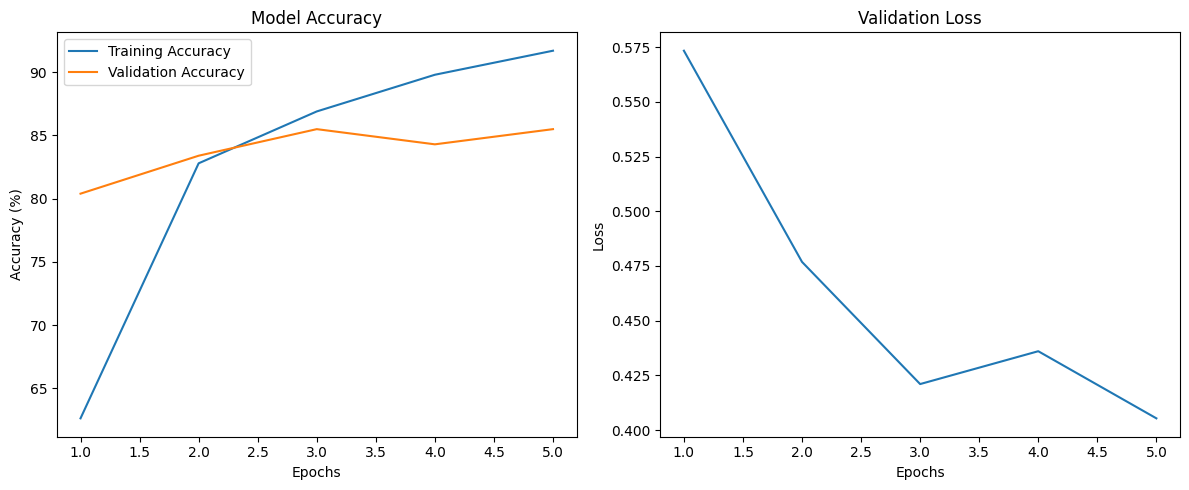

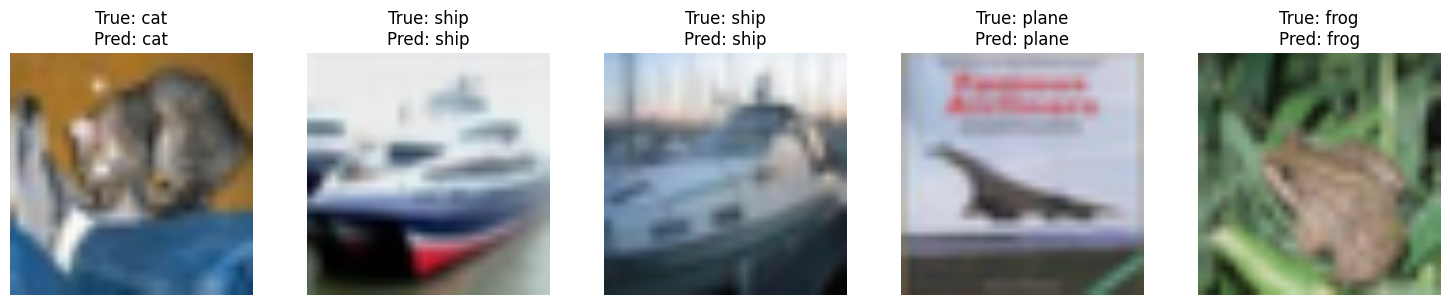

In [2]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), val_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')

plt.tight_layout()
plt.savefig('vgg16_performance.png')

def evaluate_model(model, dataloader):
    model.eval()
    correct, total = 0, 0
    class_correct = list(0. for _ in range(10))
    class_total = list(0. for _ in range(10))

    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            c = (predicted == labels).squeeze()
            for i in range(labels.size(0)):
                class_correct[labels[i]] += c[i].item()
                class_total[labels[i]] += 1

    print(f'Overall Accuracy on test images: {100 * correct / total:.2f}%')
    for i in range(10):
        print(f'Accuracy of {classes[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')

    return 100 * correct / total

print("\nEvaluating model on test data...")
test_accuracy = evaluate_model(vgg16, testloader)

def visualize_predictions(model, dataloader, classes, num_images=5):
    model.eval()
    dataiter = iter(dataloader)
    images, labels = next(dataiter)

    with torch.no_grad():
        outputs = model(images[:num_images].to(device))
        _, predicted = torch.max(outputs, 1)
        predicted = predicted.cpu().numpy()

    images = images[:num_images]
    labels = labels[:num_images]

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        img = images[i].numpy().transpose((1, 2, 0))
        img = std * img + mean
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)
        axes[i].set_title(f"True: {classes[labels[i]]}\nPred: {classes[predicted[i]]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig('predictions.png')

print("\nVisualizing some predictions...")
visualize_predictions(vgg16, testloader, classes)



Generating evaluation metrics...

Classification Report:

              precision    recall  f1-score   support

       plane     0.8529    0.8447    0.8488       103
         car     0.8252    0.9551    0.8854        89
        bird     0.7826    0.9000    0.8372       100
         cat     0.8085    0.7379    0.7716       103
        deer     0.9200    0.7667    0.8364        90
         dog     0.7423    0.8372    0.7869        86
        frog     0.8559    0.9018    0.8783       112
       horse     0.9062    0.8529    0.8788       102
        ship     0.9307    0.8868    0.9082       106
       truck     0.9495    0.8624    0.9038       109

    accuracy                         0.8550      1000
   macro avg     0.8574    0.8545    0.8535      1000
weighted avg     0.8599    0.8550    0.8552      1000



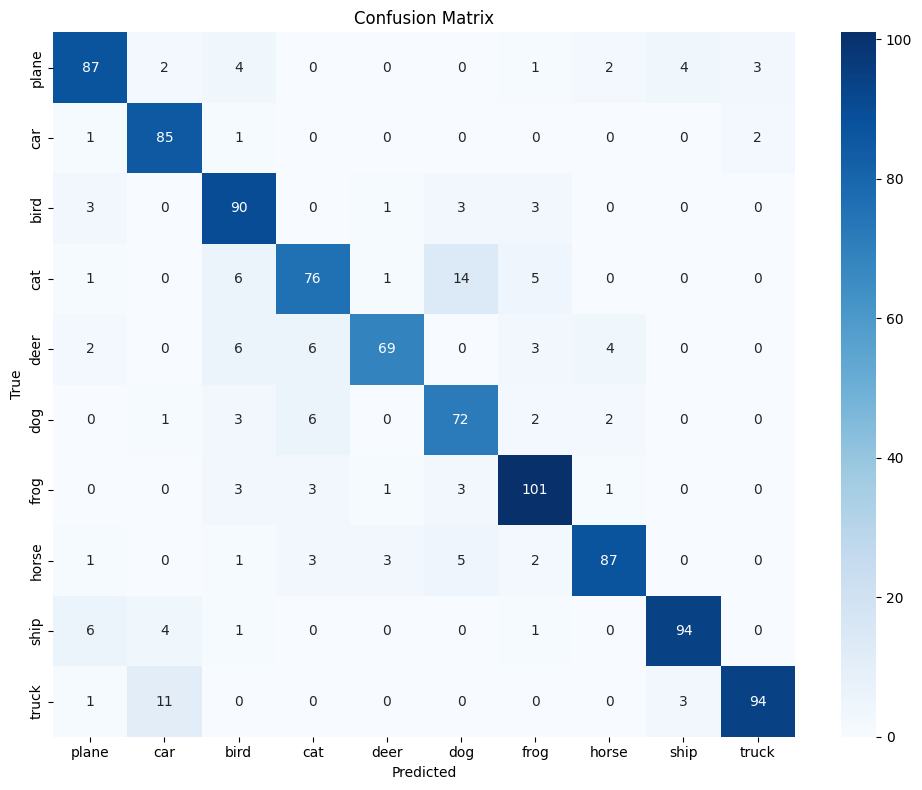

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate_with_metrics(model, dataloader, classes):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=classes, digits=4))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

print("\nGenerating evaluation metrics...")
evaluate_with_metrics(vgg16, testloader, classes)
